# Einleitung

In den Straßen New York Citys herrscht ein hohes Verkehrsaufkommen, wodurch Verkehrsunfälle an der Tagesordnung sind. Durch [NYC Open Data](https://opendata.cityofnewyork.us/) werden die erfassten Verkehrsunfälle für die Allgemeinheit zugänglich gemacht.

Thema dieses Berichtes und Thema unseres Projektes ist es, die öffentlich zugänglichen Unfalldaten zu nutzen, um darauf die im Abschnitt `Analyseziele` beschriebenen Analysen durchzuführen und die Ergebnisse zu visualisieren.

## Ausführungsplan

Bevor der eigentliche Bericht und der entsprechende Code genauer behandelt werden, wird hier erläutert, was installiert und beachtet werden muss, um einen möglichst reibungslosen Ablauf zu garantieren.

### Installation der benötigten Docker-Container

Damit keine weiteren Komponenten manuell installiert werden müssen und keine Änderungen am ausführenden System entstehen, werden alle Komponenten durch [Docker](https://docs.docker.com/get-docker/) installiert und ausgeführt. Somit wird Docker benötigt und muss installiert werden.

Die benötigten Docker-Container sind in der Docker-Compose-Konfiguration (`docker-compose.yml`) definiert.
Diese können mit `docker-compose up -d` heruntergeladen und gestartet werden. 
Mit `docker-compose down` können die gestarteten Container gestoppt werden. Das Terminal sollte nicht geschlossen werden, bevor alle Container durch `docker-compose down` gestoppt vollständig gestoppt wurden.

Durch Nutzung einer angepassten `docker-compose.yml` konnten Fehler, die mit der Verwendung einer vorgefertigten `docker-compose.yml` entstanden sind, ausgeräumt werden.

### Starten des Programmcodes

Nachdem alle Container über `docker-compose up -d` gestartet wurden, kann mit der Ausführung des Jupyter Notebooks begonnen werden. Hierbei kann unter `Kernel` die Option `Restart & Run All` genutzt werden, um das komplette Notebook auszuführen. Sollte der Code nicht auf einem Windows-System ausgeführt werden, so befindet sich im Kapitel `Starten des Join-Prozesses (außer auf Windows)` eine Art Breakpoint. Dieser Breakpoint dient (wie unten beschrieben) dazu, dass der Join-Prozess nicht ausgeführt wird, bevor alle notwendigen Daten geladen sind. Zur Ausführung des Codes unter dem Breakpoint sind die Anweisungen am Anfang des entsprechenden Kapitels zu befolgen.

## Aufbau der Data Pipeline

Für das Projekt soll eine Data-Pipeline aufgebaut werden, welche die Daten in die Datenbank lädt. 
Von dort aus sollen die Daten von einem Python-Script zur Analyse angefragt werden.

Beteiligt an der Data-Pipeline ist eine Kafka-Instanz, wobei ein Python-Script einen Producer dafür darstellt und ein weiteres Python-Script einen Consumer. Das Producer-Script lädt die Daten zeilenweise aus der Datenquelle, einer CSV-Datei, in Kafka ein, während der Consumer die Daten aus Kafka ausliest und in die MongoDB schreibt. Das Analyse-Script bezieht die Daten wiederum aus der MongoDB.

## Datenquellen

Als Datenquellen dienen die vom NYC Open Data Project bereitgestellten Unfalldaten des NYPD. Die detaillierten Unfalldaten befinden sich in drei unterschiedlichen Datenquellen die unter Anderem als CSV-Datei verfügbar sind: [Motor Vehicle Collisions](https://data.cityofnewyork.us/browse?Data-Collection_Data-Collection=Motor+Vehicle+Collisions&q=crashes).

Enthalten in den Daten sind die am Unfall beteiligten Verkehrsteilnehmer, die Verletzten und Toten, sowie die genaue Position des Unfalls. Darüberhinaus sind noch weitere Daten in den Quellen enthalten, auf die teilweise im Analyseabschnitt genauer eingegangen wird.

## Analyseziele

Nach der Verarbeitung und Aufbereitung der Daten soll aus der Analyse hervorgehen, welche saisonalen und lokalen Zusammenhänge aus den Unfalldaten gelesen werden können. Des Weiteren soll das Ergebnis eine Aussage darüber geben, ob sich bestimmte Unfallhotspots innerhalb von New York lokalisieren lassen und ob diese Hotspots sich mit der Zeit ändern. Während der Ansicht der Unfallhotspots soll es auch möglich sein, zu erkennen, an welchem Hotspot sich besonders viele schwerwiegende Unfälle ereignen (Unfälle mit vielen verletzten oder getöteten Verkehrsteilnehmern). Zuletzt soll aus der Analyse hervorgehen, welche Verkehrsteilnehmer besonders oft getötet und verletzt werden. Hierzu zählen sowohl die Füßgänger, die Fahrradfahrer als auch die Fahrer von motorisierten Fahrzeugen.

Die Visualisierung der Daten erfolgt über verschiedene Diagramme sowie eine Heatmap, welche mehrere Filtermöglichkeiten bereitstellt.

## Installation der Python Packages

Damit nicht alles vollständig von uns entwickelt werden muss, wurden verschiedene Bibliotheken verwendet. Auf diese Weise kann sich die Umsetzung auf das Wesentliche beziehen.

[Apache Kafka](https://kafka.apache.org/) soll dazu genutzt werden, mit Hilfe eines Producers und eines Consumers die Datensätze zeilenweise einzulesen. Dies wird durch die [kafka-python](https://github.com/dpkp/kafka-python) Bibliothek stark vereinfacht.

Während der Kafka Consumer die Datensätze registiert und ausliest müssen diese ein die MongoDB eingetragen werden. Um dieses Verfahren zu vereinfachen, wird die [pymongo](https://pypi.org/project/pymongo/) Bibliothek genutzt.

Nachdem alle Daten in der Datenbank sind, folgt die Auswertung der Daten. Um aus den Daten eine visuelle Darstellung in Form einer Heatmap aufbauen zu können, kommt die [folium](https://github.com/python-visualization/folium) Bibliothek zum Einsatz.

Es folgt die Installation der genannten Bibliotheken über `pip install`:

In [ ]:
pip install kafka-python pymongo folium

### Importieren benötigter Module

Damit die verschiedenen Funktionen und Datentypen der Bibliotheken genutzt werden können, müssen die entsprechenden Module importiert werden. Im folgenden Abschnitt werden einige der notwendigen Module importiert.

Zusätzlich hat sich während der Entwicklung gezeigt, dass je nach Betriebssystem Unterschiede bezüglich der Paralellisierung von Prozessen entstehen. Aus diesem Grund wird hier eine Variable `windows` deklariert, mit der während der Ausführung bestimmter Funktionen zwischen Windows und anderen Betriebssystemen unterschieden werden kann.

Bei der `DEBUG` Variable handelt es sich um eine Variable, welche beim Wert `TRUE` dafür sorgt, dass nur ein Bruchteil der Daten aus den CSV-Dateien importiert wird. Der Import aller Daten (`DEBUG = False`) kann mehrere Stunden in Anspruch nehmen, da es über 9 Millionen Zeilen sind (Stand 12.11.2020). `Mit DEBUG = True` Variable dauert der Import der Daten nur wenige Minuten.

Zuletzt wird hierbei die Breite des Jupyter Notebooks auf 100% gestellt, um die Lesbarkeit zu verbessern.

In [5]:
from kafka import KafkaProducer, KafkaConsumer
from pymongo import MongoClient
import datetime as dt
import requests
import os
from pathlib import Path
from multiprocessing import Process
from time import sleep
from data.schemas import schemas
import platform
import folium
windows = True if 'Windows' in platform.system() else False 
DEBUG = True

from IPython.core.display import display, HTML
display(HTML(
    "<style>.container { width:100% !important; }</style>"
))

# Verarbeitung der Daten

Um mit der Verarbeitung der Daten zu beginnen, müssen die Daten zunächst aufbereitet und in die MongoDB eingefügt werden. Damit mit Hilfe der MongoDB verschiedene Analysen durchgeführt werden können, sind verschiedene Schritte notwendig, welche in diesem Kapitel nacheinander erläutert und durchgeführt werden.

### Herunterladen der Datensätze

Da die Daten nur verarbeitet werden können, während sie diesem Notebook zur Verfügung stehen, müssen die Daten im ersten Schritt heruntergeladen werden. Hierzu werden die Daten von der Datenquelle mithilfe des nachfolgenden Python-Scripts heruntergeladen. Resultat sind drei `.csv`-Dateien, welche die Unfalldaten zeilenweise enthalten.
Die Dateien werden im Ordner `data` gespeichert, damit sie nur einmalig heruntergeladen werden müssen. Der Ordner befindet sich im gleichen Verzeichnis wie dieses Jupyter Notebook.

In [ ]:
if not os.path.exists('data/'):
    os.mkdir('data')

for file_name, download_url in [
    ('crashes.csv', 'https://data.cityofnewyork.us/api/'
     'views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'),
    ('vehicles.csv', 'https://data.cityofnewyork.us/api/'
     'views/bm4k-52h4/rows.csv?accessType=DOWNLOAD'),
    ('persons.csv', 'https://data.cityofnewyork.us/api/'
     'views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'),
]:
    if not os.path.isfile(fp:= (Path('data') / file_name)):
        with open(fp, 'wb') as crash_file:
            crash_file.write(requests.get(download_url).content)

### Produzieren der CSV-Daten in Kafka
Nachdem die Daten heruntergeladen wurden, beginnt die eigentliche Verarbeitung.
Im folgenden Codeabschnitt wird hierfür die Funktion `send_to_kafka` genutzt, die in das Modul `pipeline_tools.py` ausgelagert wurde. 
Die Funktion erstellt zunächst eine Instanz des `KafkaProducer`, entsprechend des angegebenen Topics.
Um die Daten zu produzieren muss zeilenweise über die entsprechende `.csv` Datei iteriert werden, wobei jedoch ein Laden der gesamten Datei in den RAM vermieden wird, da es sich um einen Generator handelt.
Nachdem eine Zeile ausgelesen wurde, wird diese in das entsprechende `topic` gesandt und muss von einem `KafkaConsumer` wieder ausgelesen werden, um die Daten nutzen zu können.

Für jedes der 3 Topics wird ein eigener Producer Process definiert.
Die einzelnen Prozesse können auf UNIX-basierten Systemen parallel ausgeführt werden, wodurch die Ausführung durch Nutzung von mehr logischen Prozessoren beschleunigt wird. 
Hierbei werden gezielt Prozesse gestartet und keine Threads, da Multithreading in Python mit geteilten Variablen in der Regel mit Race Conditions verbunden ist und daher zu unbrauchbaren Ergebnissen führt.

In [ ]:
from pipeline_tools import send_to_kafka
                
producers = {
    'crashes': Process(
        target=send_to_kafka, args=[
            'crashes', 15000 if DEBUG else None
    ]),
    'vehicles': Process(
        target=send_to_kafka, args=[
            'vehicles', 5000 if DEBUG else None
    ]),
    'persons': Process(
        target=send_to_kafka, args=[
            'persons', 5000 if DEBUG else None
    ]),
}

### Konsumieren der produzierten Daten und Import in die Datenbank

Im nächsten Schritt wird die Funktion aufgerufen, mit der die Daten aus Kafka ausgelesen und in die MongoDB eingefügt werden. Diese Funktion befindet sich ebenfalls im Modul `pipeline_tools.py`.

In der Funktion wird zunächst eine Verbindung zur MongoDB aufgebaut.
Sobald die Verbindung zur Datenbank bereit ist, wird ein `KafkaConsumer` erstellt, der das übergebene `topic` abonniert. 
Durch das Abonnieren eines Topics erhält der Consumer zeilenweise die zuvor in das Topic gelesenen Daten. 
Jede Zeile wird nach dem Einlesen zunächst in eine Liste konvertiert, indem ein CSV-Reader darauf angewandt wird. 
Da es sich um Daten im CSV-Format handelt, die Strings mit Kommas enthalten, würde ein Aufruf von `split(',')` fehlerhafte Ergebnisse liefern.

Durch das Trennen in die einzelnen Bestandteile, sind die Daten nun bereit als Key-Value Paare in das entsprechende Dokument innerhalb der MongoDB persistiert zu werden.
Dabei wird das mitgegebene Schema verwendet um die Datentypen bei Bedarf zu konvertieren.

In [ ]:
from pipeline_tools import process_topic

consumers = {
    'vehicles': Process(
        target=process_topic, args=(
        'vehicles', schemas['vehicles']
    )),
    'persons': Process(
        target=process_topic, args=(
        'persons', schemas['persons']
    )),
    'crashes': Process(
        target=process_topic, args=(
        'crashes', schemas['crashes']
    )),
}

### Starten der Prozesse

Nachdem die Funktionen, die für das Speichern der CSV-Daten in die Datenbank zuständig sind, nun fertig definiert sind, werden diese hier aufgerufen. Da die Daten zu Personen und Fahrzeugen (Topic `nyc_persons` und `nyc_vehicles`) im Anschluss an das Persistieren in der Datenbank mit den Unfällen (`crashes`) verbunden werden müssen, werden sie vollständig verarbeitet, bevor die Daten zu den Unfällen in die Datenbank geschrieben werden. 
Dies wurde für das Windows Betriebssystem und andere Betriebssysteme unterschiedlich umgesetzt:

Bei der Ausführung der Funktionen wird zwischen Microsoft Windows und anderen Betriebssystemen unterschieden:

**Windows:** Da es nicht möglich ist mehrere Child Processes im Jupyter Notebook zu starten, müssen die Funktionsaufrufe nacheinander und blockierend erfolgen. Das Problem hat sich darin geäußert, dass die Prozesse zwar ohne Fehlermeldung gestartet werden konnten, aber in keiner Form Output gezeigt haben, weder in der Datenbank, noch im Kafka-Topic oder dem Notebook selbst.
Durch die Synchronität können direkt alle Funktionen aufgerufen werden. 

**UNIX:** Hier werden die Producer für die Topics `nyc_crashes`, `nyc_vehicles`, `nyc_persons` parallel gestartet. Außerdem werden die Consumer der Topics `nyc_vehicles` und `nyc_persons` kurz darauf gestartet. Sobald die beiden Consumer-Prozesse fertig sind, was daran erkenntlich wird, wenn sie nicht mehr in die Datenbank schreiben, können die nachfolgenden Prozesse manuell gestartet werden.

In [ ]:
from pipeline_tools import aggregate_data

if windows:
    limit = send_to_kafka('vehicles', 5000 if DEBUG else None)
    process_topic('vehicles', schemas['vehicles'], limit)
    limit = send_to_kafka('persons', 5000 if DEBUG else None)
    process_topic('persons', schemas['persons'], limit)
    limit = send_to_kafka('crashes', 15000 if DEBUG else None)
    process_topic('crashes', schemas['crashes'], limit)
    
    aggregate_data()
else:
    for topic in 'persons vehicles crashes'.split(' '):
        producers[topic].start()
    sleep(2)
    for topic in 'persons vehicles'.split(' '):
        consumers[topic].start()

### Starten des Join-Prozesses (UNIX)
Im letzten Schritt muss der Prozess gestartet werden, der das Verbinden der beiden Tabellen `vehicles` und `persons` in die Daten des Topics `nyc_crashes` durchführt. Dieser Schritt wurde auf Windows bereits im vorherigen Codeabschnitt erledigt, da dieser auf Windows nicht paralellisiert wird. Das heißt, dass die Vollständigkeit der Daten bereits durch Synchronität gewährleistet wird.

Für UNIX-Systeme ist wichtig, dass die parallelisierten Prozesse zum Produzieren aller Daten und zum Einlesen der `nyc_vehicles` und `nyc_persons` Topics beendet sind. Die Ausführung des vorherigen Codeblocks sollte also abgeschlossen sein. Damit die folgende Funktion bei einem `Kernel` → `Restart & Run All` nicht zu vor Beendigung der geforkten Prozesse ausgeführt wird, wurden 2 Breakpoints eingefügt.

In [ ]:
if not windows:
    assert False, 'non-Windows breakpoint'

In [ ]:
# Ausführung erst nach Beendigung der drei Producer
if not windows:
    consumers['crashes'].start()

In [ ]:
if not windows:
    assert False, 'non-Windows breakpoint'

Die letzte Collection die in der MongoDB erstellt wird beinhaltet aggregierte Daten.
Die Funktion `aggregate_data`, die in das Modul `pipeline_tools.py` exportiert wurde, iteriert über die Daten aus der `crashes`-Collection und summiert für die einzelnen Arten von Verkehrsteilnehmern jeweils nach Jahr und nach Monat in einer geschachtelteten Collection die Toten, Verletzten und Zuschadengekommenen.

Die erstellte Collection `crashes_by_year` erlaubt Zugriff auf die aggregierten Unfallzahlen auf Jahresbasis und auf Jahres-Monats-Basis. 
Eine weitere Verschachtelung nach Tagen innerhalb der Monate, oder nach Wochen innerhalb des Jahres wäre außerdem denkbar gewesen.
Da aber die Analysemöglichkeiten bereits mit monatlicher Staffelung mehr als ausreichend sind, und eine Aggregierung der Zahlen auf Tagesebene keine Anwendung mehr gefunden hätte, haben wir diese ausgelassen.

Eine tagesbasierte Aggregation der Unfallzahlen wäre nur sinnvoll gewesen, wenn die Unfälle dadurch nachvollziehbar visualisiert worden wären, etwa in Form eines Zeitraffers auf einer animierten Karte.

In [ ]:
# Ausführung erst nach Beendigung des `nyc_crashes` Consumers
if not windows:
    aggregate_data()

# Datenvisualisierung

Da an dieser Stelle alle Daten vollständig in die Datenbank importiert und anschließend so aufbereitet wurden, dass sie für eine visuelle Analyse verwendet werden können, beginnt an dieser Stelle die Datenanalyse. Wie im Kapitel `Analyseziele` bereits erwähnt, werden zur visuellen Darstellung Diagramme und eine Heatmap genutzt, welche vor der Erstellung nochmal detailliert erläutert werden.

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

from analysis_tools import (
    monthly, monthly_sum, 
    show_graph_injury, show_graph_type
)

Im folgenden Codeabschnitt werden die aufbereiteten Daten aus der MongoDB ausgelesen, um diese für die Visualisierung zu verwenden.

In [ ]:
from pymongo import MongoClient
with MongoClient('mongodb://localhost:27017/') as client:
    database = client["nyc_crashes"]
    crashes = database.crashes
    crashes_by_year = database.crashes_by_year

## Interact
Das `interact` ermöglicht es, ein Dropdown-Menü anzeigen zu können. Dafür benötigt es die Angabe einer Funktion und einer Liste von Daten, die im Dropdown zur Auswahl stehen sollen. Wenn eine der Optionen gewählt wird, wird die angegebene Funktion, im Falle des ersten Diagramms `monthly`, mit dem ausgewählten Wert ausgeführt. Dabei wird aus der Liste nur ein einziger Wert an die Funktion übergeben. 

## Daten aus MongoDB laden
Für die Liste werden alle `_id` Elemente gesucht, die in unserem Datenmodell die Jahre darstellen. So hat der Nutzer die Möglichkeit, im Dropdown ein Jahr auszuwählen.

Die aufgerufene Funktion hat die Aufgabe, die benötigten Daten aus der MongoDB zu laden und in Form zu bringen. Für die Darstellung werden Listen mit X- und Y-Werten benötigt.
Zum Anzeigen der Daten wollten wir auf der X-Achse die Monate haben und auf der Y-Achse die Anzahl der Unfälle darstellen. Damit ist im Diagramm ein Jahresverlauf zu erkennen und die Werte sind gut mit einander vergleichbar.

## Bar Chart
Für die Darstellung griffen wir auf die Python Library `matplotlib` zurück. Diese stellt verschiedene Funktionen bereit, um Daten in verschiedenen Formen darzustellen. So können Diagramme, Scatterplots, Graphen und viele mehr damit dargestellt werden. Wir haben uns dazu entschieden, die Daten in Balkendiagrammen darzustellen.
Mit matplotlib gibt es die Möglichkeit, mehrere Daten in einem Balken darzustellen. Dies haben wir uns zur Nutze gemacht und im ersten Diagramm zwei Balken nebeneinander. Damit kann die Anzahl der verletzten Personen bei Unfällen mit der Zahl der umgekommenen Personen bei einem Unfall direkt verglichen werden.
Im zweiten Diagramm sieht man die Gesamtzahl der Unfälle, aufgeteilt danach, ob bei dem Unfall ein Fußgänger, Fahrradfahrer oder ein Kraftfahrzeug involviert war.





In [ ]:
#monthly('2019')
interact(monthly, Jahr=[data['_id'] for data in crashes_by_year.find().sort('_id', -1)]);

Aus diesem Diagram, welches sich mit der Art der Verletzung auseinandersetzt, können verschiedene Schlüsse gezogen werden.<br>
Offensichtlich erkennbar ist beispielsweise:

**1.** Die Anzahl an verletzten Personen ist bei einem Verkehrsunfall deutlich höher als die Anzahl der getöteten Personen

**2.** In den kalten Jahreszeiten (Winter & Frühling) gibt es weniger verletzte und getötete Verkehrsteilnehmer. Vermutlich sind die Leute zu dieser Zeit weniger unterwegs. Eine Ausnahme ist hierbei der Dezember, was vermutlich an den Festtagen liegt

Etwas nicht so offensichtliches, was jedoch auch aus dem Diagram hervor geht: Betrachtet man die Jahre 2012-2014 und die Jahre 2018-2020, so sieht man, dass die Letalität von Unfällen etwas abgenommen hat, was dafür spricht, dass die Verkehrsteilnehmer entweder vorsichtiger fahren oder die Sicherheit von Fahrzeugen sich über die Jahre verbessert hat.

In [ ]:
#monthly_sum('2019')
interact(monthly_sum, Jahr=[data['_id'] for data in crashes_by_year.find().sort('_id', -1)]);

Dieses Diagram, welches die Anzahl der Unfälle nach Mobilitätstyp (zu Fuß, mit dem Fahrrad, mit Kraftfahrzeugen) unterteilt gibt ebenfalls eine Auskunft darüber, dass im Frühling und im Winter weniger Unfälle passieren. Zusätzlich sieht man, dass in den kalten Jahreszeiten weniger Leute mit dem Fahrrad verunfallen. Hieraus lässt sich schließen, dass die New Yorker Bevölkerung lieber mit dem Fahrrad fährt, wenn es warm ist.

Sowohl im ersten, als auch im zweiten Diagram zeichnen sich deutlich die Auswirkungen der Coronakrise auf den Verkehr ab. In den Monaten, in denen das Coronavirus für eine Vielzahl an Lockdowns gesorgt hat (ab März), hat die Anzahl der Unfälle drastisch abgenommen. Dies spricht dafür, dass die Bürger von New York während des Lockdowns weniger unterwegs waren.

## Saisonale Analyse

In [6]:
from analysis_tools import show_line_chart

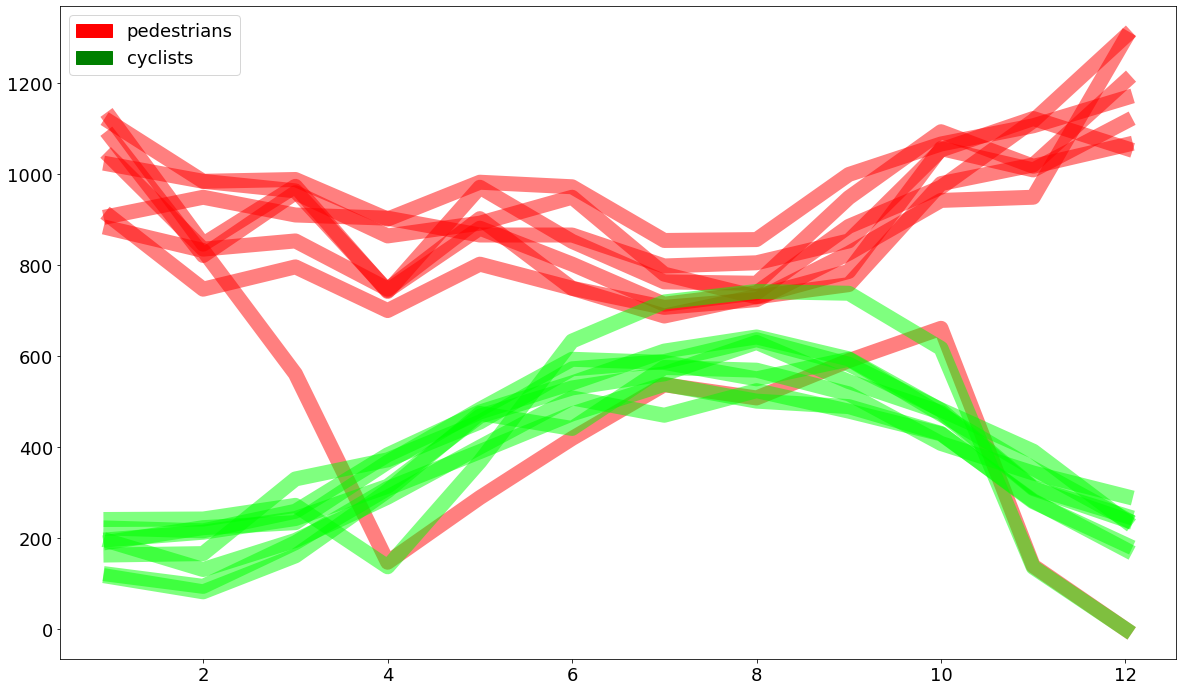

In [10]:
#show_line_chart(damage='injured', kinds=['pedestrians', 'motorists', 'cyclists'])
show_line_chart(damage='injured', kinds=['pedestrians', 'cyclists'])

Dieses Liniendiagram enthält eine Linie für jedes Jahr, für das Unfalldaten vorhanden sind. Diese Linien zeigen an, wie häufig Unfälle während der verschiedenen Monate eines Jahres passieren. Es dient also dazu noch einmal einen besseren Blick auf den Zusammenhang zwischen der Saison und den Unfällen zu erkennen. Hierbei wird nochmal verdeutlicht, was bereits aus den vorherigen Balkendiagrammen hervor geht: In den warmen Monaten eines Jahres gibt es deutlich mehr Unfälle als während den kalten Monaten. Des Weiteren sieht man auch hier, dass es viel mehr Unfälle gibt, bei denen Fahrradfahrer verletzt oder getötet werden, wenn es warm ist.

## Trendvisualisierung

In [11]:
from analysis_tools import show_stacked_victims

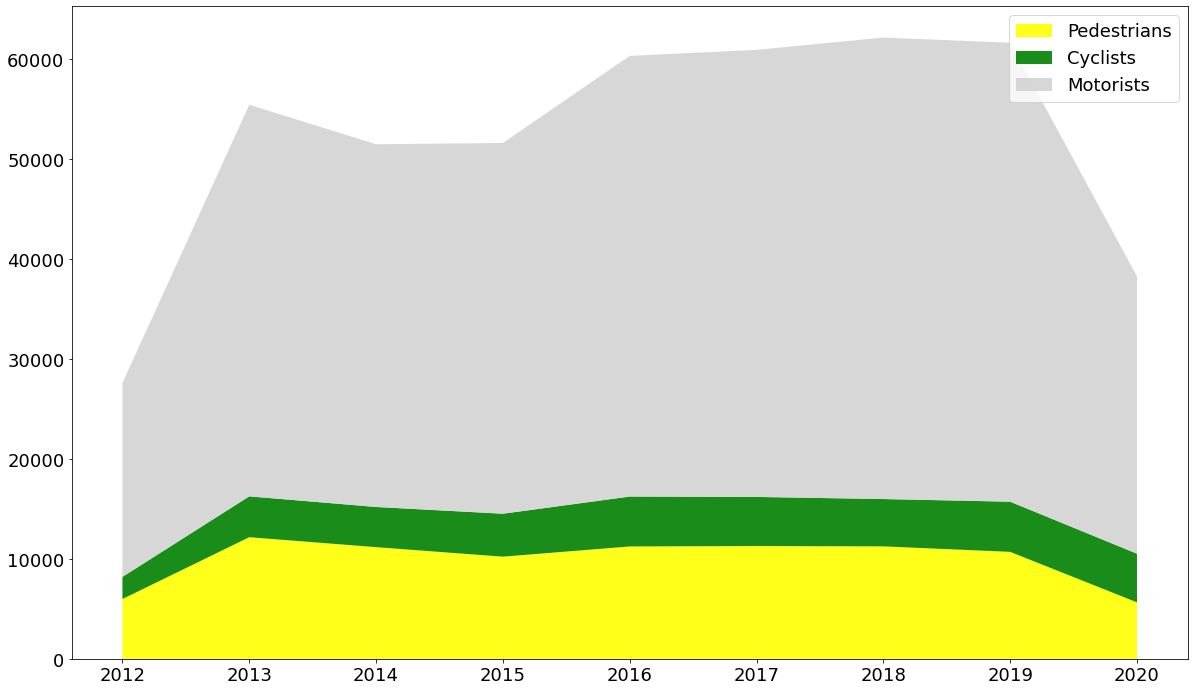

In [12]:
show_stacked_victims()

In diesem Flächendiagram sind die über die Jahre entstandenen Unfälle zu erkennen. Hierbei wird unterteilt zwischen den Unfällen, bei denen Fußgänger, Fahrradfahrer und Kraftfahrzeugfahrer verletzt wurden. Aus den visualisierten Daten wird ersichtlich, dass die Gesamtzahl an Unfällen langsam ansteigt. Im Jahr 2020 ging die Anzahl an Unfällen deutlich zurück. Dies liegt daran, dass das Jahr 2020 noch nicht beendet ist und daran, dass der durch das Coronavirus verursachte Lockdown die Menge an Verkehr in New York deutlich reduziert hat.

## Geographische Visualisierung

Mit der interaktiven Unfallkarte ist es möglich, die Daten nach verschiedenen Kriterien zu filtern und diese als Heatmap darzustellen. So können beispielsweise die Unfälle, bei denen Fußgänger verletzt wurden und die Unfälle bei denen Fußgänger getötet wurden einzeln oder gemeinsam betrachtet wurden.<br>
Alle möglichen Filter können oben Rechts auf der Karte gefunden und entsprechend an- oder abgewählt werden. Des Weiteren ist es möglich die Karte heran- und heraus zu zoomen, um einen genaueren Blick auf die Unfälle an einer beliebigen Stelle in New York zu werfen.

Die Unfallkarte wird mit Hile der Library [folium](https://github.com/python-visualization/folium) erstellt und benötigt zur Erstellung lediglich die Daten, die angezeigt werden sollen und ein wenig Konfiguration. Die Funktion `make_map()`, in der sich der Code für die Erstellung der Karte befindet wurde in das Modul `analysis_tools.py` ausgelagert.

Die Funktion verbindet sich mit der Datenbank und list alle benötigten Daten aus. 
Da die Crash-Daten von der MongoDB in den RAM geladen werden, kann dies auf Computern mit weniger als 16 GB RAM etwas länger dauern. 
Die Funktion erstellt eine Basiskarte, die Initial auf die Koordinaten New York Citys gelegt wird.
Zu der Karte werden in der Funktion verschiedene Heatmaps in Layern hinzugefügt, an denen die Toten-/ Verletzten-Dichte erkenntlich werden. 
Diese einzelnen Layer sind beschrieben und können in dem Layer Selector (oben rechts) ein- und ausgeblendet werden.

In [ ]:
from analysis_tools import make_map
crash_map = make_map()

In [ ]:
crash_map

Betrachtet man die Heatmap, so kann man anhand der verschiedenen Filter viele verschiedene Schlüsse ziehen.<br>
Zunächst wird ersichtlich, dass in New York quasi überall bereits Unfälle passiert sind.<br>
Bei genauerem Hinsehen wird auch ersichtlich, dass die Unfälle, welche sich an Kreuzungen oder Auffahrten ereignen eine höhere Letalität haben, also die Unfälle, die sich auf geraden Strecken ereignen.<br>
Zusätzlich kann festgestellt werden, dass es einige Hotspots gibt, an denen sich besonders viele Unfälle ereignen. Hierbei handelt es sich ebenfalls meist um Kreuzungen und Auffahrten.<br>
Es können noch weitere Schlüsse aus der Karte gezogen werden, welche an dieser Stelle jedoch nicht alle aufgelistet werden.

# Fazit

Nach den bereits erwähnten Startschwierigkeiten, welche sowohl dem Abstimmen zwischen Kafka Producer und Kafka Consumer, sowie dem nicht funktionierenden Multi-Processing im Jupyter Notebook (auf Windows) geschuldet waren, konnten alle Visualisierungen ohne weitere Probleme umgesetzt werden. Zur Umsetzung  der visuellen Auswertung war es notwendig, sich mit den verschiedenen Bibliotheken zur Umsetzung der Virtualisierung auseinanderzusetzen. Während der Entwicklung hat sich schnell gezeigt, dass wir nicht mit allen Daten auf einmal arbeiten können, da sonst das Testen von neuen Codeabschnitten sehr viel Zeit benötigt hätte. Aus diesem Grund kamen wir zum Entschluss, die im Abschnitt `Import benötigter Module` erläuterte `DEBUG` Variable einzufügen, damit es möglich ist, neue Codeabschnitte schneller zu testen und diese erst nach erfolgreichen Tests mit dem kompletten Datensatz auszuführen. Diese `DEBUG` Variable bietet sich auch an, wenn es darum geht, dieses Notebook zu testen, ohne womöglich über mehrere Stunden alle Daten aus den CSV-Dateien zu importieren und zu laden. Durch die visuelle Darstellung, konnten einige interessante Schlüsse gezogen werden, welche teilweise in den vorherigen Kapiteln bereits erläutert wurden. Auch so manche These wurde widerlegt. Während die Vermutung nahe stand, dass im Winter aufgrund der glatten Straßen mehr Unfälle entstehen, als im Sommer, hat sich gezeigt, dass im Winter deutlich weniger Unfälle entstehen. Womöglich hängt das damit zusammen, dass die New Yorker Verkehrsteilnehmer im Winter weniger unterwegs sind. Diese Theorie ließe sich jedoch nur überprüfen, indem man Daten auswertet, welche zusätzlich das saisonale Verkehrsaufkommen in New York zeigen.

Das Projekt hat gezeigt, dass es bei einer so großen Menge an Daten nicht mehr sinnvoll ist, Schlüsse aus wenigen, händisch ausgewerteten Daten zu ziehen. Aufgrund der verschiedenen Visualisierungen (durch die Diagramme und die Heatmap) konnte aber auch eine so große Datenmenge wie die Unfalldaten von New York sinnvoll und bequem analysiert werden. 

Zuletzt sollte festgehalten werden, dass es sinnvoll ist, die Daten über eine Bibliothek wie Apache Kafka einzulesen, da auf diese Weise keine riesige Menge an Arbeitsspeicher benötigt wird. Während in diesem Projekt die CSV-Dateien noch eine Größe hatten, die mit 16GB Arbeitsspeicher problemlos hätten eingelesen werden können, muss dies ja nicht bei allen Daten der Fall sein. In diesem Fall wäre es dann nicht mehr möglich die CSV-Dateien in den Arbeitsspeicher einzulesen, wodurch der Weg über eine Bibliothek wie Apache Kafka beinahe unvermeidlich wäre. Bei der Durchführung dieses Projektes wurde ein Einblick in den Umgang mit großen Datenmengen erlangt, welcher in Zukunft 